<a href="https://colab.research.google.com/github/ejrtks1020/Kaggle_Computer_Vision/blob/main/Brain_Tumor_Object_Detection_(Yolo_v5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. 데이터 다운로드

In [1]:
import os

os.environ['KAGGLE_USERNAME'] = 'asdsadwqrr'
os.environ['KAGGLE_KEY'] = 'fcd162570bf9e9f427cde4418405b341'

In [2]:
!mkdir brain_tumor
%cd brain_tumor

/content/brain_tumor


In [3]:
!kaggle datasets download -d davidbroberts/brain-tumor-object-detection-datasets

 73% 9.00M/12.3M [00:00<00:00, 30.3MB/s]
100% 12.3M/12.3M [00:00<00:00, 41.0MB/s]


In [ ]:
!unzip '*.zip'

#1.1. 데이터 구조

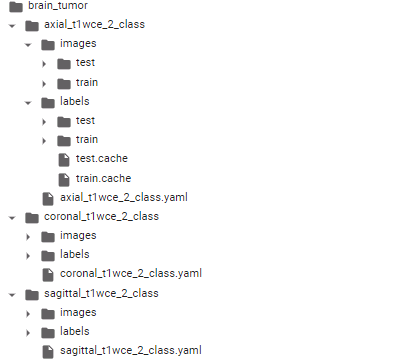

In [5]:
%cd ..

/content


#2. Ultralytics Yolo v5 설치

In [6]:
# Clone and install YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 10752, done.
remote: Total 10752 (delta 0), reused 0 (delta 0), pack-reused 10752
Receiving objects: 100% (10752/10752), 10.83 MiB | 14.86 MiB/s, done.
Resolving deltas: 100% (7434/7434), done.
/content/yolov5
     |████████████████████████████████| 596 kB 14.1 MB/s 
/content


In [7]:
os.environ['WANDB_MODE'] = 'disabled'
from IPython.display import FileLink
import shutil
from shutil import copyfile

# best weights를 저장할 경로 생성
if not os.path.exists('/content/output'):
  os.mkdir('/content/output')

#3. Annotation 정보

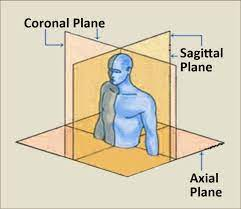

# 뇌의 단면 방향 (Plane)
* axial
* coronal
* sagittal

# 영상기법 (Series)

* t1wce

In [8]:
# 현재 데이터셋에는 T1wce만 존재
SERIES = 't1wce'
PLANE = 'axial'

# 4. 데이터 학습

In [24]:
!python yolov5/train.py --img 512 --batch 32 --epochs 30 \
--data '/content/brain_tumor/{PLANE}_{SERIES}_2_class/{PLANE}_{SERIES}_2_class.yaml' \
--weights yolov5/yolov5s.pt --cache

train: weights=yolov5/yolov5s.pt, cfg=, data=/content/brain_tumor/axial_t1wce_2_class/axial_t1wce_2_class.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=30, batch_size=32, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl

In [25]:
copyfile('/content/yolov5/runs/train/exp2/weights/best.pt', f'/content/drive/MyDrive/Brain_Tumor/{PLANE}_{SERIES}_2_class.pt')

'/content/drive/MyDrive/Brain_Tumor/axial_t1wce_2_class.pt'

#5. 이미지 Detection

In [13]:
!mkdir detect_output

In [28]:
!python yolov5/detect.py --weights /content/yolov5/runs/train/exp2/weights/best.pt \
--conf 0.25 --source /content/brain_tumor/axial_t1wce_2_class/images/test --project detect_output

detect: weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], source=/content/brain_tumor/axial_t1wce_2_class/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=detect_output, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/75 /content/brain_tumor/axial_t1wce_2_class/images/test/00018_101.jpg: 640x640 1 negative, 1 positive, Done. (0.007s)
image 2/75 /content/brain_tumor/axial_t1wce_2_class/images/test/00018_109.jpg: 640x640 1 negative, Done. (0.007s)
image 3/75 /content/brain_tumor/axial_t1wce_2_class/images/test

In [27]:
!rm -rf /content/detect_output/exp

In [55]:
# ground truth 이미지와 labels, predicted 이미지 경로 저장
gt_imgs = []
pred_imgs = []
gt_labels = []

gt_dir = '/content/brain_tumor/axial_t1wce_2_class/images/test'
gt_labels_dir = '/content/brain_tumor/axial_t1wce_2_class/labels/test'
pred_dir = '/content/detect_output/exp'

test_imgs = os.listdir('/content/brain_tumor/axial_t1wce_2_class/images/test')

for img in test_imgs:
  gt_imgs.append(os.path.join(gt_dir, img))
  pred_imgs.append(os.path.join(pred_dir, img))
  gt_labels.append(os.path.join(gt_labels_dir, img.replace('.jpg', '.txt')))

In [49]:
pred_imgs[:5]

['/content/detect_output/exp/00084_145.jpg',
 '/content/detect_output/exp/00019_75.jpg',
 '/content/detect_output/exp/00081_80.jpg',
 '/content/detect_output/exp/00081_89.jpg',
 '/content/detect_output/exp/00018_121.jpg']

In [50]:
gt_imgs[:5]

['/content/brain_tumor/axial_t1wce_2_class/images/test/00084_145.jpg',
 '/content/brain_tumor/axial_t1wce_2_class/images/test/00019_75.jpg',
 '/content/brain_tumor/axial_t1wce_2_class/images/test/00081_80.jpg',
 '/content/brain_tumor/axial_t1wce_2_class/images/test/00081_89.jpg',
 '/content/brain_tumor/axial_t1wce_2_class/images/test/00018_121.jpg']

156 169 42 34
(135, 152) (177, 186)
153 137 23 16
(141, 129) (164, 145)


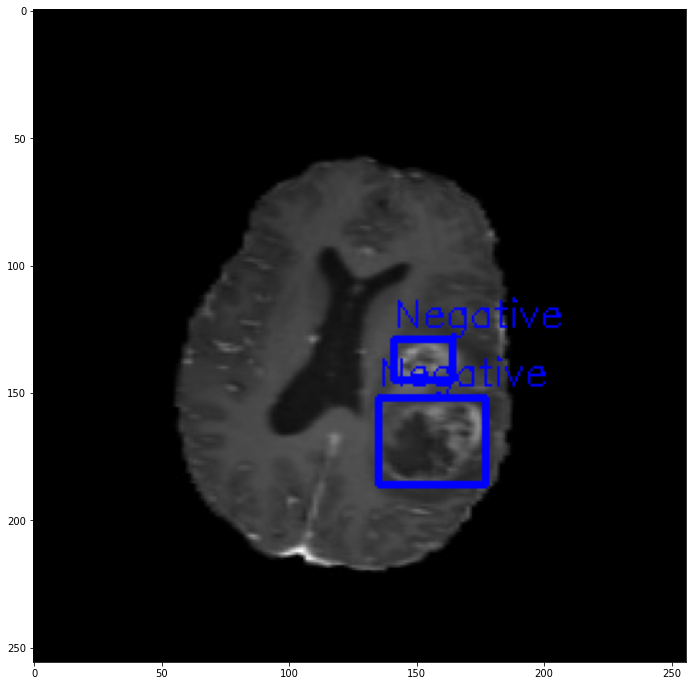

In [72]:
# 이미지 파일과 annotation 파일을 불러와서 시각화
h, w = 256, 256
img = cv2.cvtColor(cv2.imread('/content/brain_tumor/axial_t1wce_2_class/images/test/00018_101.jpg'), cv2.COLOR_BGR2RGB)

with open('/content/brain_tumor/axial_t1wce_2_class/labels/test/00018_101.txt', 'r') as f:
  for line in f:
    l = list(map(float, line.strip('\n').split(' ')))
    # yolo data format은 bounding box의 중심좌표(l[1], l[2])와 박스의 너비와 높이(l[3], l[4])로 저장되어 있으며 이미지 크기를 기준으로 0 ~ 1사이 값으로 scaling 되어있음
    # 따라서 width와 height를 곱해서 원래값을 구한다.
    center_x, center_y = int(l[1] * w), int(l[2] * h)  
    box_w, box_h = int(l[3] * w), int(l[4] * h)
    print(center_x, center_y, box_w, box_h)

    # opencv로 bounding box를 그리기 위해 좌상단, 우하단 좌표를 계산
    left = int(center_x - (box_w / 2))
    top = int(center_y - (box_h / 2))
    right = int(left + box_w)
    bottom = int(top + box_h)

    # 레이블(l[0]) 값에따라 박스와 caption의 색을 지정
    # Negative일 경우 Blue, Positive일 경우 Red
    if int(l[0]) == 0:
      caption = 'Negative'
      box_color = (0, 0, 255)
      caption_color = (0, 0, 255)
    else:
      caption = 'Positive'
      box_color = (255, 0, 0)
      caption_color = (255, 0, 0)

    print((left, top), (right, bottom))
    cv2.rectangle(img, (left,top), (right, bottom), color = box_color, thickness = 2)
    cv2.putText(img, caption, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, caption_color, 1)

plt.figure(figsize=(12, 12))
plt.imshow(img)
    


    


In [75]:
def draw_box(img, annot):
  h, w = img.shape[:2]
  with open(annot, 'r') as f:
    for line in f:
      l = list(map(float, line.strip('\n').split(' ')))
      center_x, center_y = int(l[1] * w), int(l[2] * h)
      box_w, box_h = int(l[3] * w), int(l[4] * h)

      left = int(center_x - (box_w / 2))
      top = int(center_y - (box_h / 2))
      right = int(left + box_w)
      bottom = int(top + box_h)

      if int(l[0]) == 0:
        caption = 'Negative'
        box_color = (0, 0, 255)
        caption_color = (0, 0, 255)
      else:
        caption = 'Positive'
        box_color = (255, 0, 0)
        caption_color = (255, 0, 0)

      cv2.rectangle(img, (left,top), (right, bottom), color = box_color, thickness = 2)
      cv2.putText(img, caption, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, caption_color, 1)

  return img
      

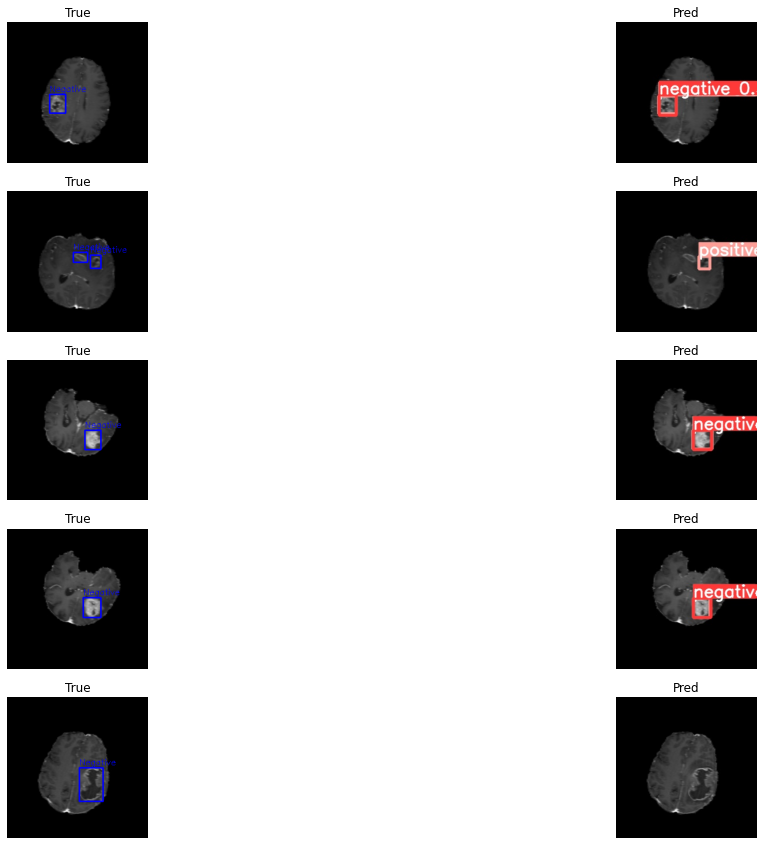

In [76]:
import matplotlib.pyplot as plt
import cv2

fig, ax = plt.subplots(5, 2, figsize = (20, 15))

for i in range(5):

  gt_img = cv2.cvtColor(cv2.imread(gt_imgs[i]), cv2.COLOR_BGR2RGB)
  gt_bbox_img = draw_box(gt_img, gt_labels[i])
  ax[i, 0].imshow(gt_bbox_img)
  ax[i, 0].set_title('True')
  ax[i, 0].axis('off')

  pred_img = cv2.cvtColor(cv2.imread(pred_imgs[i]), cv2.COLOR_BGR2RGB)
  ax[i, 1].imshow(pred_img)
  ax[i, 1].set_title('Pred')
  ax[i, 1].axis('off')

